In [77]:
#import needed packages
import sklearn
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


In [ ]:
#TODO:
#
#
#
#
#


In [2]:
df_raw = pd.read_csv('/home/ec2-user/haystax/interview-data-science/anomaly_data.csv')

In [3]:
df_raw.shape

(25152, 2)

In [4]:
df_raw.dtypes

Person Id                int64
Door Access DateTime    object
dtype: object

In [5]:
df_raw.head(10)

,Person Id,Door Access DateTime
0,1,10/1/15 8:02
1,2,10/1/15 8:02
2,3,10/1/15 8:03
3,4,10/1/15 8:04
4,5,10/1/15 8:04
5,6,10/1/15 8:07
6,7,10/1/15 8:07
7,8,10/1/15 8:07
8,9,10/1/15 8:07
9,10,10/1/15 8:14


In [6]:
#convert the string to a date time object so I can use time operations 
df_raw['Door Access DateTime'] = pd.to_datetime(df_raw['Door Access DateTime'])

In [7]:
df_raw.head(10)

,Person Id,Door Access DateTime
0,1,2015-10-01 08:02:00
1,2,2015-10-01 08:02:00
2,3,2015-10-01 08:03:00
3,4,2015-10-01 08:04:00
4,5,2015-10-01 08:04:00
5,6,2015-10-01 08:07:00
6,7,2015-10-01 08:07:00
7,8,2015-10-01 08:07:00
8,9,2015-10-01 08:07:00
9,10,2015-10-01 08:14:00


In [8]:
df_raw['Door Access DateTime'].describe()

count                   25152
unique                  14760
top       2015-11-25 13:21:00
freq                        8
first     2015-10-01 08:02:00
last      2015-12-31 23:26:00
Name: Door Access DateTime, dtype: object

In [9]:
#double check everything is in 2015
max(df_raw['Door Access DateTime'].dt.year)- min(df_raw['Door Access DateTime'].dt.year)

0

In [10]:
df_raw.describe()

,Person Id
count,25152.000000
mean,50.256759
std,28.740784
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [11]:
#there are no missing IDs (like 69 not being there or something)
#so this feels like simulated data- too clean
df_raw['Person Id'].nunique()

100

In [12]:
#evewryone in here shows up at least 168 times so there are no rogue interlopers 
df_raw['Person Id'].value_counts().describe()

count    100.000000
mean     251.520000
std       10.074951
min      168.000000
25%      248.000000
50%      252.000000
75%      256.000000
max      276.000000
Name: Person Id, dtype: float64

In [13]:
######Feature Creation#######
df_features = []
df_features = df_raw

df_features['Month'] = df_features['Door Access DateTime'].dt.month 
df_features['Day'] = df_features['Door Access DateTime'].dt.day
df_features['MonthDay'] = df_features['Month'].map(str)+ "/" + df_features['Day'].map(str)
df_features['Minute'] = df_features['Door Access DateTime'].dt.minute
#caclulate the number of days someone was in the building (to be used as denominator later)
df_features['Hour'] = df_features['Door Access DateTime'].dt.hour
df_features['DayofWeek'] = df_raw['Door Access DateTime'].dt.dayofweek

#get the first and last time there was a login or out for the day
df_startend = df_features.groupby(['MonthDay', 'Person Id']).agg(['min', 'max'])['Door Access DateTime']

#get the overall first/last time that a person comes into work
#if we had a longer dataset, this should be also by weekday but the current
#number of observations is just too small to warrant that, means would be sensitive
#to the precise outliers we want to detect and trimming means would also result in a lot of data loss



In [14]:
#compute the average minute that is a person's first and last time to swipe in or outs
df_startend['Start Minute'] = pd.to_numeric(df_startend['min'].dt.hour) *60.0 + pd.to_numeric(df_startend['min'].dt.minute) *1.0
df_startend['End Minute'] = pd.to_numeric(df_startend['max'].dt.hour) *60.0 + pd.to_numeric(df_startend['min'].dt.minute) *1.0
df_avg_startend = df_startend.groupby('Person Id').mean()

{'boxes': [<matplotlib.lines.Line2D at 0x7f165bb645c0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f165be2df28>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f165be2d278>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f165be2d6d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f165bb64748>,
  <matplotlib.lines.Line2D at 0x7f165bb64c88>]}

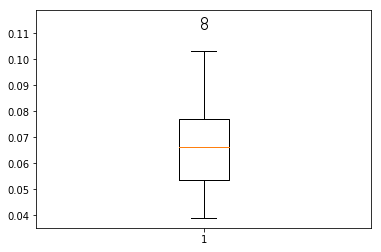

In [15]:
#find the percentage of the time people very precisely hit a specific minute interval
#while there are not any in this dataset, a super high percentage of
#people doing this might indicate the data admin is tampering with the data, the data is bad due to collection
#or be a good 'strange behavior flag' if someone who was compulsively on the end of a shift stopped being so  

pct0 = df_features[df_features['Minute'].isin(['0','15','30','45'])].groupby('Person Id').count()/df_features.groupby('Person Id').count()
plt.boxplot(pct0['Minute'])

In [16]:
#there are 0 people who have an odd number of times going in and out of the building
#there are no 'ghosts' or people letting their friend in behind them 
min(df_features.groupby('Person Id').count()['MonthDay']%2)

0

In [17]:
daily_attendance = df_features.groupby('MonthDay').count()['Person Id']/2

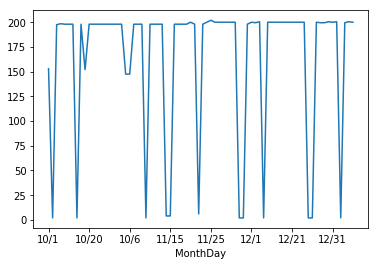

In [18]:
#chart to get an idea of what is happening, looks like regular weekens and some holidays
ts = pd.Series(daily_attendance)
ts.plot()

In [19]:
#they didn't take Colombus day off and seem to work hard on some random weekend days 
#did take Christmas off- need to purely norm off of their behavior, not just a weekend tag
#presence on Christmas Even and black Friday makes it feel like a retail location
daily_attendance.sort_values()

MonthDay
10/10      2.0
12/5       2.0
12/26      2.0
12/25      2.0
12/13      2.0
11/8       2.0
10/18      2.0
11/7       2.0
11/1       2.0
11/15      4.0
11/14      4.0
11/21      6.0
10/6     147.5
10/5     147.5
10/2     152.0
10/1     153.0
10/12    197.5
10/28    198.0
10/15    198.0
11/9     198.0
10/16    198.0
10/19    198.0
10/27    198.0
10/14    198.0
11/23    198.0
11/19    198.0
11/18    198.0
11/17    198.0
11/16    198.0
10/20    198.0
         ...  
12/3     199.5
12/10    199.5
12/7     199.5
12/24    200.0
12/31    200.0
12/2     200.0
12/23    200.0
12/22    200.0
12/21    200.0
12/28    200.0
12/18    200.0
11/5     200.0
12/16    200.0
11/2     200.0
11/24    200.0
11/27    200.0
12/17    200.0
11/30    200.0
11/3     200.0
11/6     200.0
12/1     200.0
12/14    200.0
12/15    200.0
11/4     200.0
12/9     200.0
12/11    200.5
12/30    200.5
12/4     200.5
12/8     200.5
11/25    202.0
Name: Person Id, Length: 76, dtype: float64

In [115]:
pd.DataFrame(daily_attendance).reset_index()

,MonthDay,Person Id
0,10/1,153.0
1,10/10,2.0
2,10/12,197.5
3,10/13,198.5
4,10/14,198.0
5,10/15,198.0
6,10/16,198.0
7,10/18,2.0
8,10/19,198.0
9,10/2,152.0


In [21]:
df_attendance = pd.DataFrame(daily_attendance)
df_attendance.columns = ['Total Attendance']
###note, right here is where we should go in and make a 'non-attender' day/person file for the function call db


df_features = pd.merge(df_attendance, df_features, left_index = True, right_on = 'MonthDay')

In [22]:
#if there were 10X fewer people there than usual, you get flagged
cutoff = df_attendance['Total Attendance'].mean()/10
weird_days = df_attendance[df_attendance['Total Attendance']<cutoff]
weird_days

,Total Attendance
MonthDay,
10/10,2.0
10/18,2.0
11/1,2.0
11/14,4.0
11/15,4.0
11/21,6.0
11/7,2.0
11/8,2.0
12/13,2.0


In [23]:
GhostTown = df_features[df_features['MonthDay'].isin(weird_days.index)]

In [24]:
#when putting this into a function kick out people who are there above XX ghost days (as its their alternate schedule) 
#feature: Ghost
GhostTown.groupby('Person Id').agg({"Person Id": pd.Series.count, "MonthDay": pd.Series.nunique})

,Person Id,MonthDay
Person Id,,
5,20,4
48,16,4
70,20,5
84,8,2


In [120]:
###figure out who is coming in more than 4 times in a day

missed_swipe = df_features.groupby(['MonthDay', 'Person Id']).count()['Door Access DateTime']%2
#list of missing a swipe on a particular day 
missed_swipe = missed_swipe[missed_swipe>0]

In [122]:
#among non-badge swipers there is exactly one person who is above average and should be looked at
miss_list = missed_swipe.groupby('Person Id').sum()
miss_list= miss_list[miss_list>miss_list.mean()]
pd.DataFrame(miss_list)

,Door Access DateTime
Person Id,
72,12


In [138]:
df_cluster = df_features.drop(['MonthDay', 'Person Id',  'Door Access DateTime'], axis=1)
df_cluster = pd.merge(df_cluster, pd.get_dummies(df_cluster.DayofWeek), left_index = True, right_index=True)
df_cluster = df_cluster.drop(['DayofWeek'], axis=1)
X = StandardScaler().fit_transform(df_cluster)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-3.014978,-1.234397,-1.663730,-1.579237,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
1,-3.014978,-1.234397,-1.663730,-1.579237,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
2,-3.014978,-1.234397,-1.663730,-1.521420,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
3,-3.014978,-1.234397,-1.663730,-1.463603,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
4,-3.014978,-1.234397,-1.663730,-1.463603,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
5,-3.014978,-1.234397,-1.663730,-1.290152,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
6,-3.014978,-1.234397,-1.663730,-1.290152,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
7,-3.014978,-1.234397,-1.663730,-1.290152,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
8,-3.014978,-1.234397,-1.663730,-1.290152,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905
9,-3.014978,-1.234397,-1.663730,-0.885432,-1.387692,-0.502397,-0.502831,-0.509339,1.987758,-0.478503,-0.03786,-0.030905


In [28]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

In [29]:
db

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [30]:
labels = db.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)


In [31]:
labels_unique

array([-1,  0,  1,  2,  3,  4])

In [32]:
k=4
my_members = labels == k
cluster_outlier = {}

In [33]:
for i in labels_unique:
    if np.where(db.labels_ == i)[0].shape[0] < 25000/400:
        cluster_outlier = set(list(cluster_outlier)) | set(list(np.where(db.labels_ == i)[0]))
        print(i)

0
1
2
3
4


In [34]:
len(cluster_outlier)

216

In [35]:
brc = Birch(branching_factor=50, n_clusters=None, threshold=1.5,compute_labels=True)
brc.fit(X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
   threshold=1.5)

In [36]:
labels = brc.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

69

In [37]:
if np.where(brc.labels_ == 2)[0].shape[0] < 25000/400:
    print('yay')

In [38]:
cluster_outlier ={}

for i in labels_unique:
    if np.where(brc.labels_ == i)[0].shape[0] < 25000/400:
        cluster_outlier = set(list(cluster_outlier)) | set(list(np.where(brc.labels_ == i)[0]))
        #print(i)

In [39]:
len(cluster_outlier)

65

In [143]:
#isolation forest 
#guessing that 1 percent of the data is from someone bad
IForest = IsolationForest( contamination=.01)
IForest.fit( df_cluster)
I_Pred = IForest.predict(df_cluster)
I_Pred

array([-1, -1, -1, ...,  1,  1,  1])

In [144]:
df_ipred = pd.DataFrame(I_Pred, columns={'Outlier'})
#gets index of where I_Pred thinks there are outliers
set(df_ipred[df_ipred['Outlier']==-1].index) | set([2,3])

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 16,
 17,
 18,
 19,
 20,
 21,
 36,
 37,
 38,
 39,
 99,
 208,
 209,
 210,
 211,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 309,
 2690,
 2691,
 2692,
 2693,
 2694,
 2695,
 2696,
 2697,
 2698,
 2706,
 2707,
 2708,
 2709,
 2710,
 2711,
 2725,
 2726,
 2727,
 2728,
 2857,
 2858,
 2896,
 2897,
 2898,
 2899,
 2900,
 2901,
 2902,
 2916,
 2917,
 2918,
 2919,
 2920,
 2921,
 2922,
 2923,
 2924,
 2925,
 2926,
 2927,
 2928,
 2929,
 2930,
 2931,
 2932,
 2933,
 2934,
 2935,
 2936,
 2937,
 2938,
 2939,
 2940,
 2941,
 2942,
 2943,
 2944,
 2967,
 2968,
 2969,
 2970,
 2971,
 2972,
 2973,
 2974,
 297

In [ ]:
#tried one class SVM but it was not running quickly so abandoned it as it seems like it wouldn't scale well

In [111]:
X_outliers  = LocalOutlierFactor(n_neighbors=100, contamination =.01)

In [112]:
df_outlier = pd.DataFrame(X_outliers.fit_predict(df_cluster), columns={'Local Outlier'}) 

In [113]:
df_outlier[df_outlier['Local Outlier']==-1].shape

(252, 1)